In [19]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [20]:
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing import image as image_loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [21]:
import tensorflow as tf

In [22]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


Define hyper parameter

In [24]:
Image_Width = 224
Image_Height = 224
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3



Batch_Size = 32
lr=1e-2
loss_function = "categorical_crossentropy"
Epochs = 50

Define Paths

In [25]:
#main_path = "datasets/misc/lspd/images/aliakbar"
main_path = "/tf/dataset/cavity_images_100perCavity"
#train_path = main_path + "/train"
#test_path = main_path + "/test"
#validation_path = main_path + "/validation"
checkpoint_filepath = "check_point.h5"
tensorboard_log = "logs"
model_save_path = "."

Dataset Preparation

In [26]:
main_datagen = ImageDataGenerator(
    rotation_range=10, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    horizontal_flip=True, # horizontal flip
    brightness_range=[0.2,1.2],
    validation_split=0.2,
) 

train_generator = main_datagen.flow_from_directory(
    directory=main_path,
    target_size=Image_Size,
    subset="training",
    class_mode='categorical',
    color_mode="rgb",
    batch_size=Batch_Size,
    shuffle=True,
    seed=2020 # to make the result reproduciblec
)
test_generator = main_datagen.flow_from_directory(
    directory=main_path,
    target_size=Image_Size,
    subset="validation",
    class_mode='categorical',
    color_mode="rgb",
    batch_size=Batch_Size,
    shuffle=True,
    seed=2020 # to make the result reproduciblec
)
Num_Class=train_generator.num_classes
#class_names =  train_generator.class_names
#sample = next(train_generator)
#print(sample[0].shape)


Found 663 images belonging to 8 classes.
Found 163 images belonging to 8 classes.


In [27]:
train_generator.next()[0][-1]

array([[[145., 145., 145.],
        [145., 145., 145.],
        [145., 145., 145.],
        ...,
        [147., 147., 147.],
        [147., 147., 147.],
        [145., 145., 145.]],

       [[145., 145., 145.],
        [145., 145., 145.],
        [145., 145., 145.],
        ...,
        [147., 147., 147.],
        [146., 146., 146.],
        [146., 146., 146.]],

       [[145., 145., 145.],
        [145., 145., 145.],
        [145., 145., 145.],
        ...,
        [147., 147., 147.],
        [146., 146., 146.],
        [146., 146., 146.]],

       ...,

       [[ 75.,  75.,  75.],
        [ 76.,  76.,  76.],
        [ 77.,  77.,  77.],
        ...,
        [ 29.,  29.,  29.],
        [ 40.,  40.,  40.],
        [ 52.,  52.,  52.]],

       [[ 81.,  81.,  81.],
        [ 82.,  82.,  82.],
        [ 83.,  83.,  83.],
        ...,
        [ 29.,  29.,  29.],
        [ 39.,  39.,  39.],
        [ 51.,  51.,  51.]],

       [[ 90.,  90.,  90.],
        [ 92.,  92.,  92.],
        [ 94.,  

In [28]:
for sample in train_generator:
    image = sample[0].astype('uint8')
#    print(image)
    break


Plot somr Datas

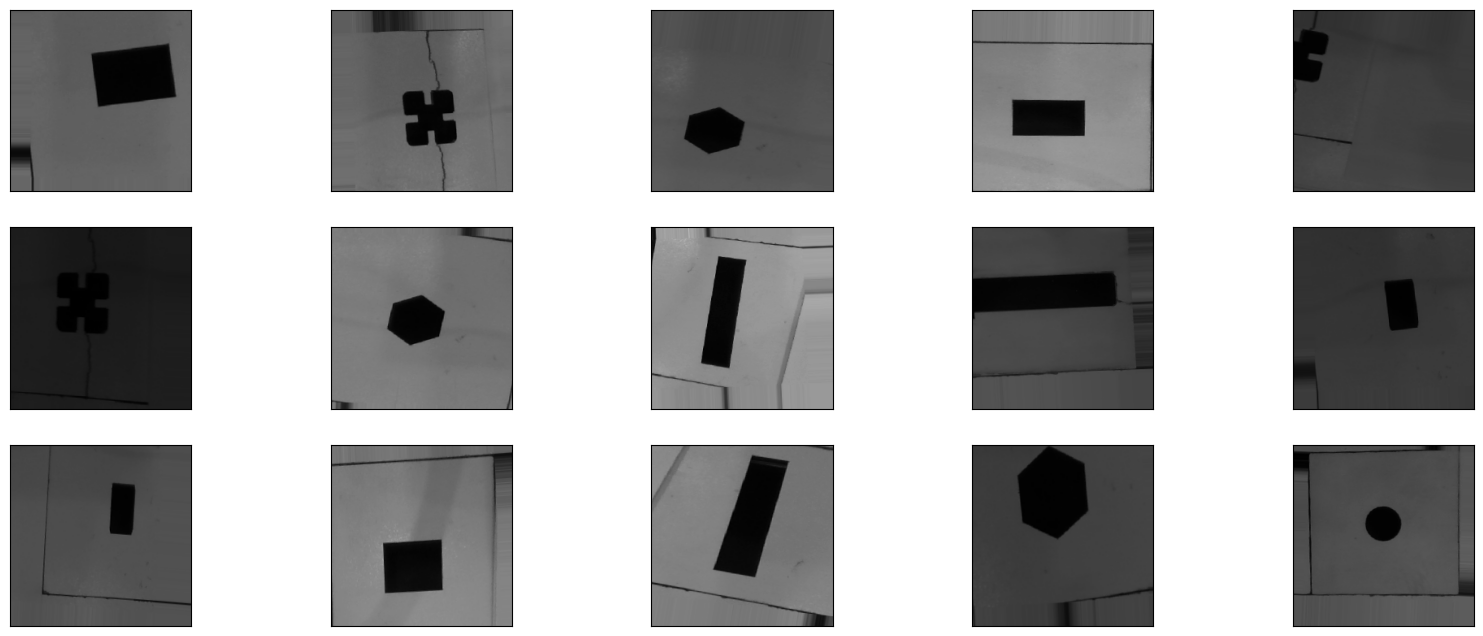

In [29]:
figure = plt.figure(figsize=(20, 8))
for i in range(15) :
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    image = next(train_generator)[0][-1].astype('uint8')
    #plt.title(class_names[labels[i]])

    ax.imshow(np.squeeze(image))
    

ReduceLROnPlateau = https://keras.io/api/callbacks/reduce_lr_on_plateau/ -> reduce lr when no improvment
EarlyStopping     = https://keras.io/api/callbacks/early_stopping/       -> stop training if no improvment
ModelCheckpoint   = https://keras.io/api/callbacks/model_checkpoint/     -> save checkpoint
TensorBoard       = https://keras.io/api/callbacks/tensorboard/          -> tensorboard

In [30]:
earlystop               = EarlyStopping(patience=10)
tensorboard             = TensorBoard(log_dir=tensorboard_log,histogram_freq=1,update_freq='batch',profile_batch=True ,write_graph=True,write_images=True,write_steps_per_second=True)
checkpoint              = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_accuracy',mode='max',save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
callbacks               = [earlystop, learning_rate_reduction,checkpoint,tensorboard]

2023-04-20 17:22:43.832690: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-20 17:22:43.832744: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-04-20 17:22:44.191786: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-04-20 17:22:44.204952: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed


In [31]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Build Model

In [32]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2, EfficientNetV2B0 
import tensorflow as tf

#model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/classification/2"
#model = hub.KerasLayer(model_handle, trainable= False)
#type(model)

def model_builder():
    inputs = layers.Input(shape=(Image_Width, Image_Height, Image_Channels))
    model = preprocess_input(inputs)
    model = EfficientNetV2B0(include_top=False, input_tensor=model, weights="imagenet")
    #model = hub.KerasLayer(model_handle, trainable= False),
    
    # Freeze the pretrained weights
    #model.trainable = True
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(Num_Class, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer, loss=loss_function, metrics=["accuracy","MeanSquaredError","AUC"]
    )
    return model
model = model_builder()

Start Training

In [33]:

history = model.fit(
    train_generator,
    epochs=Epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // Batch_Size,
    steps_per_epoch=train_generator.samples // Batch_Size,
    callbacks=callbacks
)

Epoch 1/50


2023-04-20 17:22:59.861156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-20 17:22:59.900364: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-20 17:22:59.900416: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-04-20 17:23:05.018927: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 1/20 [>.............................] - ETA: 2:12 - loss: 2.3136 - accuracy: 0.1562 - mean_squared_error: 0.1171 - auc: 0.5464

2023-04-20 17:23:06.721242: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-04-20 17:23:06.729380: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed
2023-04-20 17:23:06.794955: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 724 callback api events and 712 activity events. 
2023-04-20 17:23:06.816104: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


20/20 [==============================] - ETA: 0s - loss: 3.3716 - accuracy: 0.1157 - mean_squared_error: 0.1422 - auc: 0.5032

2023-04-20 17:23:12.624370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 20s 713ms/step - loss: 3.3716 - accuracy: 0.1157 - mean_squared_error: 0.1422 - auc: 0.5032 - val_loss: 2.5244 - val_accuracy: 0.1250 - val_mean_squared_error: 0.1236 - val_auc: 0.4990 - lr: 0.0100
Epoch 2/50
20/20 [==============================] - 12s 630ms/step - loss: 3.0345 - accuracy: 0.1632 - mean_squared_error: 0.1338 - auc: 0.5405 - val_loss: 2.1401 - val_accuracy: 0.1375 - val_mean_squared_error: 0.1114 - val_auc: 0.5134 - lr: 0.0100
Epoch 3/50
20/20 [==============================] - 12s 607ms/step - loss: 2.7656 - accuracy: 0.1664 - mean_squared_error: 0.1280 - auc: 0.5464 - val_loss: 2.2054 - val_accuracy: 0.1437 - val_mean_squared_error: 0.1123 - val_auc: 0.5192 - lr: 0.0100
Epoch 4/50
20/20 [==============================] - 11s 571ms/step - loss: 2.6996 - accuracy: 0.1521 - mean_squared_error: 0.1276 - auc: 0.5459 - val_loss: 2.2284 - val_accuracy: 0.1187 - val_mean_squared_error: 0.1135 - val_auc: 0.4928 - lr: 0.0100
Epoch 5/50


Save Models

In [38]:
now = datetime.now()
 
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print(model_save_path+'/'+dt_string+'EfficientNetV2B0'+'.h5')

model.save(model_save_path+'/'+dt_string+'EfficientNetV2B0'+'.h5')

./20-04-2023_18-10-11EfficientNetV2B0.h5


In [39]:
from keras.models import load_model
model = load_model('/tf/PPT/bbox_classification/classification_model.h5')

OSError: No file or directory found at /tf/PPT/bbox_classification/classification_model.h5

In [42]:
#test_path = "/tf/dataset/cavity_images/M20_100_horizontal/M20_100_horizontal_021.jpg"
test_path = "/tf/dataset/cavity_images_100perCavity"

Predict For check data

In [43]:
folders = os.listdir(test_path)

images_path = []
for folder in folders :
    
    for image in os.listdir(test_path+'/'+folder):
        #print(image)
        path = test_path+'/'+folder+'/'+image
        #print(path)
        images_path.append(path)
        

In [44]:
len(images_path)

826

In [45]:
def image_predict(image_path):
    
    img = image_loader.load_img(image_path,target_size=(224,224))
    img_tensor = image_loader.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)   
    return img_tensor


In [46]:
random.shuffle(images_path)
labels = train_generator.class_indices
print(labels)


{'F20_20_horizontal': 0, 'M20_100_horizontal': 1, 'M20_30_horizontal': 2, 'M20_30_vertical': 3, 'R20_horizontal': 4, 'R20_vertical': 5, 'S40_40_horizontal': 6, 'S40_40_virtical': 7}


In [47]:
labels = dict((v, k) for k, v in labels.items())
print(labels)


{0: 'F20_20_horizontal', 1: 'M20_100_horizontal', 2: 'M20_30_horizontal', 3: 'M20_30_vertical', 4: 'R20_horizontal', 5: 'R20_vertical', 6: 'S40_40_horizontal', 7: 'S40_40_virtical'}


1/1 [==============================] - 2s 2s/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 39ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 32ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 32ms/step
<class 'numpy.int64'> 0
1/1 [==============================] - 0s 21ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 26ms/step
<class 'numpy.int64'> 4
1/1 [==============================] - 0s 29ms/step
<class 'numpy.int64'> 6
1/1 [==============================] - 0s 30ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 26ms/step
<class 'numpy.int64'> 2
1/1 [==============================] - 0s 28ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 28ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 26ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 28ms/step
<class 'numpy.int64'> 1
1/1 [=========

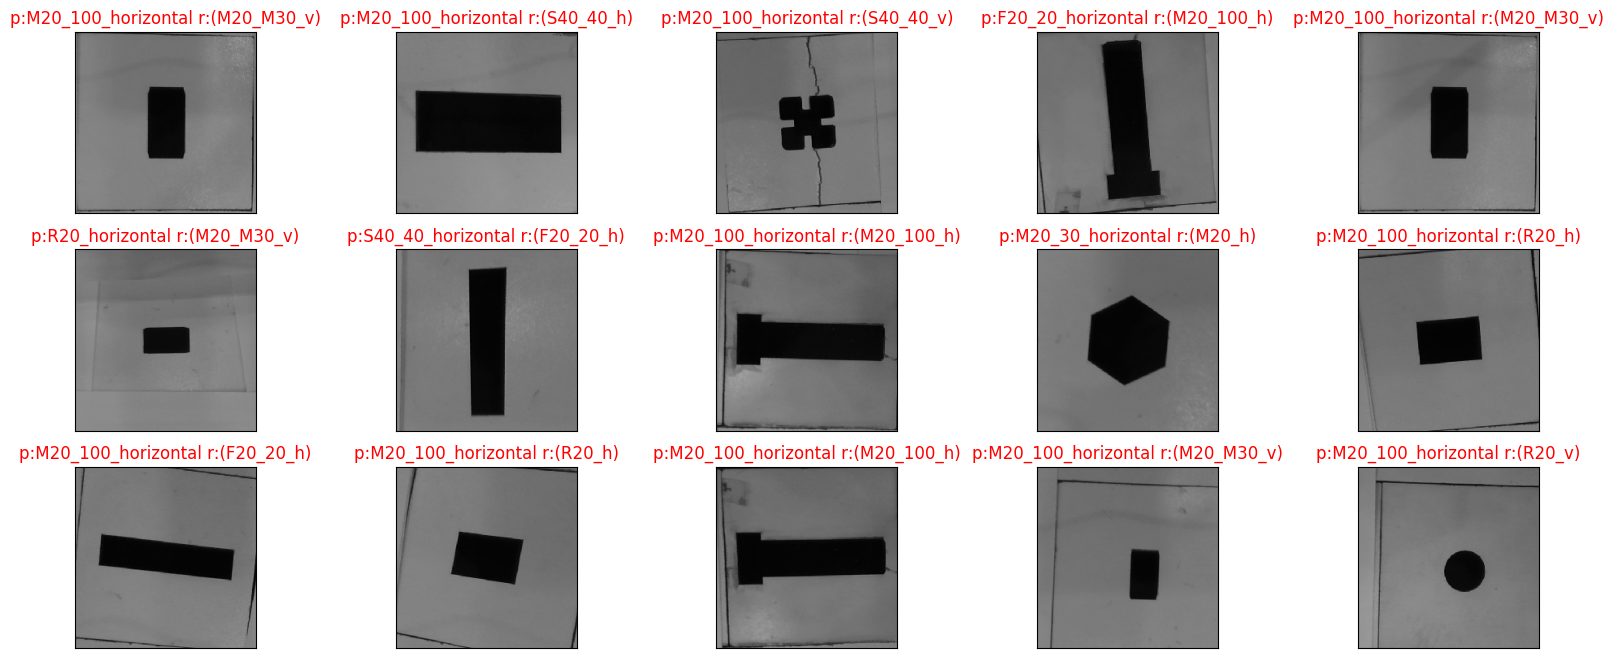

In [48]:
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i,img_path in enumerate( images_path[0:15]):
    
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    
    # Display each image
    image = image_loader.load_img(img_path, target_size=Image_Size)
    ax.imshow(np.squeeze(image))
    
    image_to_predict = image_predict(img_path)
    predict = np.argmax(model.predict(image_to_predict))
    print(type(predict), predict)
    #true_label = "porn" if '/p_' in img_path else "normal"
    true_label = '_'.join(img_path.split('/')[-1].split('.')[0].split('_')[0:-1])
    #print(true_label)
    ax.set_title(f"p:{labels[predict]} r:({true_label})", color=("green" if true_label == labels[predict] else "red"))
    #ax.set_title("True" if labels[predict] == true_label else f"p:{labels[predict]} r:({true_label})",
    #             color=("green" if true_label == labels[predict] else "red"))

In [ ]:
from keras.models import load_model
del model
model = load_model('25_03_2022.22_11_26.h5')

In [50]:
y_pred = []
y_test = []

folders = os.listdir(test_path)

labels = dict((v, k) for k, v in labels.items())
for folder in folders:
    items = os.listdir(test_path+"/"+folder)
    random.shuffle(items)
    counter = 0
    for item in items:
            image_to_predict = image_predict(test_path+"/"+folder+"/"+item)
            
            predict = np.argmax(model.predict(image_to_predict))
            real_class = folder
            
            print(f"predict:{labels[predict]}, real_id:{real_class} ")
            y_pred.append(labels[predict])
            y_test.append(real_class)
            

1/1 [==============================] - 0s 116ms/step
predict:M20_100_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 28ms/step
predict:M20_100_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 26ms/step
predict:M20_30_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 28ms/step
predict:R20_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 28ms/step
predict:M20_30_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 26ms/step
predict:M20_30_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 26ms/step
predict:M20_30_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 27ms/step
predict:M20_30_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 27ms/step
predict:M20_100_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 27ms/step
predict:M20_30_horizontal, real_id:R20

1/1 [==============================] - 0s 29ms/step
predict:M20_100_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 29ms/step
predict:M20_100_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 28ms/step
predict:M20_30_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 28ms/step
predict:M20_30_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 27ms/step
predict:M20_30_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 27ms/step
predict:M20_100_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 28ms/step
predict:R20_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 29ms/step
predict:R20_horizontal, real_id:R20_vertical 
1/1 [==============================] - 0s 24ms/step
predict:M20_100_horizontal, real_id:R20_v

1/1 [==============================] - 0s 29ms/step
predict:M20_100_horizontal, real_id:M20_100_horizontal 
1/1 [==============================] - 0s 27ms/step
predict:F20_20_horizontal, real_id:M20_100_horizontal 
1/1 [==============================] - 0s 28ms/step
predict:M20_100_horizontal, real_id:M20_100_horizontal 
1/1 [==============================] - 0s 29ms/step
predict:F20_20_horizontal, real_id:M20_100_horizontal 
1/1 [==============================] - 0s 27ms/step
predict:M20_100_horizontal, real_id:M20_100_horizontal 
1/1 [==============================] - 0s 27ms/step
predict:F20_20_horizontal, real_id:M20_100_horizontal 
1/1 [==============================] - 0s 27ms/step
predict:M20_100_horizontal, real_id:M20_100_horizontal 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:M20_100_horizontal 
1/1 [==============================] - 0s 27ms/step
predict:R20_horizontal, real_id:M20_100_horizontal 
1/1 [==============================

1/1 [==============================] - 0s 31ms/step
predict:M20_100_horizontal, real_id:R20_horizontal 
1/1 [==============================] - 0s 30ms/step
predict:R20_horizontal, real_id:R20_horizontal 
1/1 [==============================] - 0s 33ms/step
predict:M20_100_horizontal, real_id:R20_horizontal 
1/1 [==============================] - 0s 30ms/step
predict:M20_100_horizontal, real_id:R20_horizontal 
1/1 [==============================] - 0s 32ms/step
predict:M20_100_horizontal, real_id:R20_horizontal 
1/1 [==============================] - 0s 25ms/step
predict:M20_100_horizontal, real_id:R20_horizontal 
1/1 [==============================] - 0s 30ms/step
predict:R20_horizontal, real_id:R20_horizontal 
1/1 [==============================] - 0s 28ms/step
predict:M20_100_horizontal, real_id:R20_horizontal 
1/1 [==============================] - 0s 23ms/step
predict:M20_100_horizontal, real_id:R20_horizontal 
1/1 [==============================] - 0s 32ms/step
predict:R20_horizont

1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 36ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 34ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 33ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 30ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 29ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 30ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 27ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 32ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 28ms/step
pre

1/1 [==============================] - 0s 27ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 27ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 27ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 29ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 28ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 28ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:S40_40_virtical 
1/1 [==============================] - 0s 25ms/step
pre

1/1 [==============================] - 0s 26ms/step
predict:S40_40_horizontal, real_id:S40_40_horizontal 
1/1 [==============================] - 0s 28ms/step
predict:S40_40_horizontal, real_id:S40_40_horizontal 
1/1 [==============================] - 0s 26ms/step
predict:S40_40_horizontal, real_id:S40_40_horizontal 
1/1 [==============================] - 0s 21ms/step
predict:S40_40_horizontal, real_id:S40_40_horizontal 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:S40_40_horizontal 
1/1 [==============================] - 0s 26ms/step
predict:S40_40_horizontal, real_id:S40_40_horizontal 
1/1 [==============================] - 0s 28ms/step
predict:M20_100_horizontal, real_id:S40_40_horizontal 
1/1 [==============================] - 0s 25ms/step
predict:S40_40_horizontal, real_id:S40_40_horizontal 
1/1 [==============================] - 0s 21ms/step
predict:S40_40_horizontal, real_id:S40_40_horizontal 
1/1 [==============================] - 0s 25

1/1 [==============================] - 0s 28ms/step
predict:M20_100_horizontal, real_id:F20_20_horizontal 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:F20_20_horizontal 
1/1 [==============================] - 0s 26ms/step
predict:F20_20_horizontal, real_id:F20_20_horizontal 
1/1 [==============================] - 0s 27ms/step
predict:F20_20_horizontal, real_id:F20_20_horizontal 
1/1 [==============================] - 0s 27ms/step
predict:S40_40_horizontal, real_id:F20_20_horizontal 
1/1 [==============================] - 0s 29ms/step
predict:F20_20_horizontal, real_id:F20_20_horizontal 
1/1 [==============================] - 0s 26ms/step
predict:F20_20_horizontal, real_id:F20_20_horizontal 
1/1 [==============================] - 0s 32ms/step
predict:S40_40_horizontal, real_id:F20_20_horizontal 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:F20_20_horizontal 
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 31ms/step
predict:M20_100_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 29ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 32ms/step
predict:S40_40_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 26ms/step
predict:R20_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 33ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 24ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 29ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 27ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 29ms/

1/1 [==============================] - 0s 32ms/step
predict:R20_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 30ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 31ms/step
predict:M20_100_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 30ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 33ms/step
predict:R20_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 25ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 28ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 28ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 27ms/step
predict:M20_30_horizontal, real_id:M20_30_horizontal 
1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 27ms/step
predict:M20_100_horizontal, real_id:M20_30_vertical 
1/1 [==============================] - 0s 27ms/step
predict:M20_100_horizontal, real_id:M20_30_vertical 
1/1 [==============================] - 0s 29ms/step
predict:M20_30_horizontal, real_id:M20_30_vertical 
1/1 [==============================] - 0s 29ms/step
predict:M20_100_horizontal, real_id:M20_30_vertical 
1/1 [==============================] - 0s 27ms/step
predict:R20_horizontal, real_id:M20_30_vertical 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:M20_30_vertical 
1/1 [==============================] - 0s 26ms/step
predict:M20_100_horizontal, real_id:M20_30_vertical 
1/1 [==============================] - 0s 28ms/step
predict:M20_30_horizontal, real_id:M20_30_vertical 
1/1 [==============================] - 0s 28ms/step
predict:M20_30_horizontal, real_id:M20_30_vertical 
1/1 [==============================] - 0s 23ms/step
predict:M2

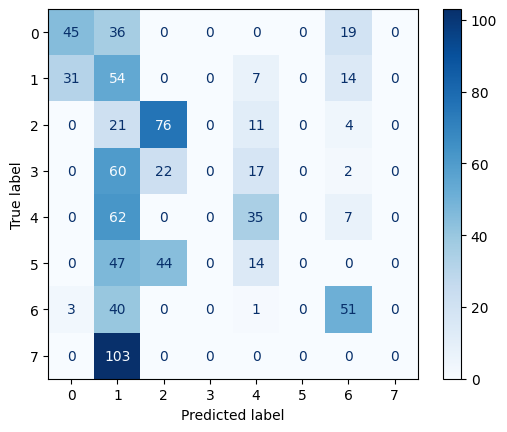

In [51]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()